## Módulos

In [ ]:
!pip install -q yfinance

In [ ]:
#Cotações do Yahoo Finance
import yfinance as yf

# Tratamento de Dados
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

#Gráficos
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

#Utilidades
from datetime import date

## Funções

In [ ]:
def busca_cadastro_cvm(data=(date.today()-BDay(2))):
  if data is not busca_cadastro_cvm.__defaults__[0]:
    data = pd.to_datetime(data)

  try:
    url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'.format(data.year, data.month, data.day)
    return pd.read_csv(url, sep=';', encoding='ISO-8859-1')

  except:
    print("Arquivo {} não encontrado!".format(url))
    print("Forneça outra data!")

In [ ]:
def busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim, freq='MS')
  informe_completo = pd.DataFrame()

  for data in datas:
    try:
      url ='http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}{:02d}.zip'.format(data.year, data.month)
      informe_mensal = pd.read_csv(url, sep=';')

    except:
      print("Arquivo {} não encontrado!".format(url))

    informe_completo = pd.concat([informe_completo, informe_mensal], ignore_index=True)

  return informe_completo

In [ ]:
def melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe=''):
  cadastro      = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
  fundos        = informes[informes['NR_COTST'] >= minimo_de_cotistas]
  cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()

  fundos = fundos.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO')
  cotas_normalizadas = fundos['VL_QUOTA'] / fundos['VL_QUOTA'].iloc[0]

  if classe == 'multimercado':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Multimercado']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'acoes':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Ações']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'rendafixa':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Renda Fixa']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'cambial':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Cambial']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  #melhores
  melhores = pd.DataFrame()
  melhores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=False)[:top] - 1) * 100
  for cnpj in melhores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    melhores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    melhores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    melhores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  #piores
  piores = pd.DataFrame()
  piores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=True)[:top] - 1) * 100
  for cnpj in piores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    piores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    piores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    piores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  return melhores, piores

In [ ]:
def consulta_fundo(informes, cnpj):
  fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
  fundo.set_index('DT_COMPTC', inplace=True)
  fundo['cotas_normalizadas'] = (fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0])*100
  return fundo

In [ ]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12

  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True)

  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

## Benckmarks

In [ ]:
cdi = cdi_acumulado('2022-01-01', '2022-12-31') * 100
cdi

,valor
data,
2022-01-03,100.000000
2022-01-04,100.069510
2022-01-05,100.104283
2022-01-06,100.139068
2022-01-07,100.173866
...,...
2022-12-26,112.162954
2022-12-27,112.219919
2022-12-28,112.276914


In [ ]:
ibov = yf.download('^BVSP', start='2022-01-01', end='2022-12-31')['Close']
ibov = (ibov / ibov.iloc[0])*100

[*********************100%%**********************]  1 of 1 completed


## Buscando Dados da CVM

In [ ]:
cadastro = busca_cadastro_cvm()
cadastro

<ipython-input-3-3c912d81f294>:7: DtypeWarning: Columns (14,17,18,20,22,24,27,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(url, sep=';', encoding='ISO-8859-1')


,TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR,INVEST_CEMPR_EXTER,CLASSE_ANBIMA
0,FACFIF,00.000.684/0001-21,DEUTSCHE BANK FDO APLIC QUOTAS FDO INV FINANCEIRO - MAX,2003-04-30,1994-12-20,19.0,2000-08-01,CANCELADA,2000-08-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FACFIF,00.000.731/0001-37,ITAMARITI CASH FUNDO APLICACAO QUOTAS FDOS INVESTIMENTO,2003-04-30,1994-05-18,40681.0,1996-01-26,CANCELADA,1996-01-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FACFIF,00.000.732/0001-81,FUNDO APLIC. QUOTAS DE F.I. SANTANDER CURTO PRAZO,2003-04-30,1994-05-24,27.0,1999-09-03,CANCELADA,1999-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FACFIF,00.000.740/0001-28,FUNDO DE APLIC EM QUOTAS DE FUNDOS DE INV BMC 60 DIAS URV,2003-04-30,1994-05-23,40690.0,1996-06-10,CANCELADA,1996-06-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FACFIF,00.000.749/0001-39,BALANCE FUNDO APLICACAO QUOTAS FUNDO INVESTIMENTO FINANCEIRO,2003-04-30,1994-05-12,35.0,2000-06-26,CANCELADA,2000-06-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75705,FUNCINE,31.674.280/0001-47,MEDIA VENTURE ESG INCENTIVADO - FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL,2018-10-26,2018-09-13,418001.0,NaN,LIQUIDAÇÃO,2023-07-21,NaN,...,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,16.549.480/0001-84,RSM BRASIL AUDITORES INDEPENDENTES LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN,NaN,NaN
75706,FUNCINE,32.222.962/0001-81,Fundo de Financiamento da Indústria Cinematográfica Nacional de Minas Gerais,2018-12-20,2018-11-14,418002.0,2021-10-29,CANCELADA,2021-10-29,NaN,...,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES LTDA.,15.489.568/0001-95,INTRA INVESTIMENTOS DTVM LTDA,NaN,NaN,NaN,NaN
75707,FUNCINE,48.879.897/0001-00,FUNDO DE FINANCIAMENTO DA INDÚSTRIA CINEMATOGRÁFICA NACIONAL - FUNCINE CEDRO LIGOCKI,2022-12-13,2022-12-01,422001.0,NaN,FASE PRÉ-OPERACIONAL,2022-12-13,2022-12-13,...,18.190.296/0001-16,CEDRO ASSET MANAGEMENT LTDA,19.280.834/0001-26,NEXT AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN,NaN,NaN
75708,FUNCINE,52.714.528/0001-26,INVESTIMAGE 4 - FUNDO DE FINANCIAMENTO DA INDÚSTRIA CINEMATOGRÁFICA,2023-10-30,2023-10-17,423001.0,NaN,FASE PRÉ-OPERACIONAL,2023-10-30,2023-10-30,...,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,19.280.834/0001-26,NEXT AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN,NaN,NaN


In [ ]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio='2022-01', data_fim='2022-12')
informes

,TP_FUNDO,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
0,FI,00.017.024/0001-53,2022-01-03,1075476.00,28.110273,1078462.74,0.0,0.00,1
1,FI,00.017.024/0001-53,2022-01-04,1075873.10,28.118682,1078785.36,0.0,0.00,1
2,FI,00.017.024/0001-53,2022-01-05,1076280.19,28.127768,1079133.95,0.0,0.00,1
3,FI,00.017.024/0001-53,2022-01-06,1076680.92,28.137115,1079492.53,0.0,0.00,1
4,FI,00.017.024/0001-53,2022-01-07,1073899.79,28.146295,1076721.79,0.0,3122.94,1
...,...,...,...,...,...,...,...,...,...
5954283,FI,97.929.213/0001-34,2022-12-26,76684544.17,10.090893,76683936.62,0.0,0.00,2
5954284,FI,97.929.213/0001-34,2022-12-27,76630935.46,10.089582,76673974.55,0.0,0.00,2
5954285,FI,97.929.213/0001-34,2022-12-28,76731693.06,10.110976,76836557.37,0.0,0.00,2
5954286,FI,97.929.213/0001-34,2022-12-29,67616216.48,10.130240,76982947.68,0.0,0.00,2


#FUNDOS MULTIMERCADO

In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=1000, classe='multimercado')


<ipython-input-5-486ba0872cea>:6: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  fundos = fundos.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO')


In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
23.799.268/0001-30,45.476688,ESH THETA 18 FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,7.558140e+07
19.628.666/0001-17,43.003483,EXPLORITAS ALPHA AMERICA LATINA FUNDO DE INVESTIMENTO EM COTAS DE FI MULTIMERCADO,Fundo Multimercado,2.243071e+08
29.732.926/0001-53,36.834965,IBIUNA LONG SHORT ADVISORY FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,2.266376e+08
18.391.138/0001-24,36.784366,IBIUNA LONG SHORT STLS FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,8.217025e+08
36.233.783/0001-09,36.598435,ACESSO IBIUNA LONG SHORT 2 MULTIMERCADO FIC FI,Fundo Multimercado,1.828437e+08


## Fundos de Ações

In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=1000, classe='acoes')

<ipython-input-5-486ba0872cea>:6: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  fundos = fundos.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO')


In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
10.590.125/0001-72,146.462645,BRADESCO FUNDO DE INVESTIMENTO EM AÇÕES CIELO,Fundo de Ações,1.377759e+07
10.869.628/0001-81,143.851064,BB AÇÕES CIELO FUNDO DE INVESTIMENTO,Fundo de Ações,4.508963e+07
17.593.934/0001-87,73.342432,BB AÇÕES BB SEGURIDADE FUNDO DE INVESTIMENTO EM AÇÕES,Fundo de Ações,1.173805e+08
03.917.778/0001-58,42.449553,ITAÚ AÇÕES PETROBRÁS - FUNDO DE INVESTIMENTO,Fundo de Ações,3.455022e+08
08.336.054/0001-34,42.410789,SICREDI - FUNDO DE INVESTIMENTO EM AÇÕES PETROBRAS,Fundo de Ações,1.455943e+08


In [ ]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
24.874.367/0001-00,-55.674175,INTER + IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM AÇÕES,Fundo de Ações,2.369667e+07
42.730.566/0001-19,-52.323148,VITREO BLOCKCHAIN AÇÕES FUNDO DE INVESTIMENTO EM AÇÕES BDR NÍVEL I,Fundo de Ações,1.873038e+06
34.218.752/0001-45,-49.507423,EMPIRICUS EXPONENCIAL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,Fundo de Ações,2.376338e+07
36.017.669/0001-33,-46.062348,EMPIRICUS TECH SELECT FUNDO DE INVESTIMENTO EM AÇÕES - BDR NÍVEL I,Fundo de Ações,2.030197e+08
33.913.562/0001-85,-45.609218,MS GLOBAL OPPORTUNITIES DÓLAR ADVISORY FIC FIA IE,Fundo de Ações,6.878865e+08


### Graficos

In [ ]:
cotas = pd.DataFrame()
fundos_destaque = pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [ ]:
cotas

Fundo de Investimento,BRADESCO FUNDO DE INVESTIMENTO EM AÇÕES CIELO,BB AÇÕES CIELO FUNDO DE INVESTIMENTO,BB AÇÕES BB SEGURIDADE FUNDO DE INVESTIMENTO EM AÇÕES,ITAÚ AÇÕES PETROBRÁS - FUNDO DE INVESTIMENTO,SICREDI - FUNDO DE INVESTIMENTO EM AÇÕES PETROBRAS,INTER + IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM AÇÕES,VITREO BLOCKCHAIN AÇÕES FUNDO DE INVESTIMENTO EM AÇÕES BDR NÍVEL I,EMPIRICUS EXPONENCIAL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,EMPIRICUS TECH SELECT FUNDO DE INVESTIMENTO EM AÇÕES - BDR NÍVEL I,MS GLOBAL OPPORTUNITIES DÓLAR ADVISORY FIC FIA IE
2022-01-03,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2022-01-04,96.743946,96.938337,99.753071,101.265667,100.375609,96.847513,99.586219,97.516774,98.846340,100.484551
2022-01-05,96.302557,96.495670,98.542010,97.112908,96.497169,90.422596,95.767618,92.756363,95.152228,98.870201
2022-01-06,94.112828,94.317040,99.208911,97.016106,96.427937,90.099717,95.192625,94.063002,94.174679,95.371838
2022-01-07,93.670867,93.877461,96.129566,97.806449,96.873932,90.251678,92.976108,95.248568,93.083870,95.255775
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,241.445780,238.779366,171.059287,144.484896,144.787561,43.938947,47.094348,50.327936,52.875580,53.015755
2022-12-27,239.125065,236.600913,170.798976,145.403423,145.707129,43.810801,47.078017,47.896762,53.243487,54.001545
2022-12-28,245.108672,242.489239,172.955230,144.646797,144.025890,44.466174,46.454730,48.726645,52.151101,54.099289
2022-12-29,246.478265,243.860507,173.350955,142.453970,142.411883,44.330333,47.678036,50.205355,53.896605,54.704367


In [ ]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores e Piores Fundos de Ações do 1º Semestre de 2022')
fig.update_layout(legend_orientation="h")

fig.show()

FUNDOS DE RENDA FIXA


In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=1000, classe='rendafixa')

<ipython-input-5-486ba0872cea>:6: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.



In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
27.389.622/0001-00,19.964377,VANQUISH PIPA FIRF LP,Fundo de Renda Fixa,3.598912e+07
11.952.873/0001-10,19.054354,BTG PACTUAL EXPLORER RENDA FIXA ATIVA FUNDO DE INVESTIMENTO LONGO PRAZO,Fundo de Renda Fixa,2.375012e+09
40.498.539/0001-37,15.835241,ITAÚ OPTIMUS RENDA FIXA LONGO PRAZO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo de Renda Fixa,6.582659e+09
35.789.436/0001-96,15.320123,ARX EVEREST ADVISORY FI EM COTAS DE FUNDOS DE INVESTIMENTO RENDA FIXA CRÉDITO PRIVADO,Fundo de Renda Fixa,7.452338e+08
32.102.131/0001-76,15.297327,ARX EVEREST FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO RENDA FIXA CRÉDITO PRIVADO,Fundo de Renda Fixa,3.204661e+08


## Fundos Cambial


In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=1000, classe='cambial')

<ipython-input-5-486ba0872cea>:6: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.



In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
24.633.789/0001-86,-4.229289,SICREDI - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR LONGO PRAZO,Fundo Cambial,2.662275e+07
33.144.687/0001-98,-4.407620,BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,1.752908e+08
31.132.386/0001-19,-4.455841,TREND DOLAR FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,2.242761e+08
20.077.065/0001-42,-4.517140,MAPFRE FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,1.034257e+07
37.306.612/0001-17,-4.568093,ITAÚ INDEX CAMBIAL DÓLAR FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,2.596196e+08


In [ ]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
04.305.193/0001-40,-10.967288,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,1.008379e+08
37.569.678/0001-08,-9.600741,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,1.069856e+07
02.497.034/0001-69,-5.791063,ITAÚ CAMBIAL DÓLAR - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,1.113230e+07
03.319.016/0001-50,-5.298550,BV DÓLAR CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,1.911722e+08
28.516.058/0001-01,-5.175810,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL ÁGORA,Fundo Cambial,1.241582e+07


### Grafico de Cotas

In [ ]:
cotas = pd.DataFrame()
fundos_destaque =  pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [ ]:
cotas

Fundo de Investimento,SICREDI - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR LONGO PRAZO,BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL,TREND DOLAR FUNDO DE INVESTIMENTO CAMBIAL,MAPFRE FUNDO DE INVESTIMENTO CAMBIAL,ITAÚ INDEX CAMBIAL DÓLAR FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,ITAÚ CAMBIAL DÓLAR - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BV DÓLAR CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL ÁGORA
2022-01-03,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2022-01-04,100.467088,100.472689,100.471016,100.440363,100.468736,100.927534,100.467694,100.462865,100.469942,100.471146
2022-01-05,100.371034,100.378924,100.375627,100.349918,100.374949,100.940054,100.375242,100.362095,100.372929,100.376165
2022-01-06,100.446232,100.455604,100.451009,100.423896,100.450321,101.240863,100.313097,100.431871,100.446187,100.451570
2022-01-07,99.519293,99.523495,99.518807,99.535187,99.525811,101.176448,99.820726,99.497165,99.513195,99.518323
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,93.957340,93.797182,93.755902,93.721381,93.662548,88.299553,88.424495,92.481860,92.958518,93.044867
2022-12-27,95.328975,95.189729,95.140992,95.079528,95.034668,90.126486,89.714095,93.831873,94.321108,94.414226
2022-12-28,94.871509,94.711691,94.665610,94.621610,94.559238,89.736457,89.012965,93.357176,93.838073,93.954500
2022-12-29,95.723523,95.544597,95.497342,95.436481,95.385730,88.991964,89.792952,94.167499,94.656459,94.779177


In [ ]:
cotas

Fundo de Investimento,SICREDI - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR LONGO PRAZO,BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL,TREND DOLAR FUNDO DE INVESTIMENTO CAMBIAL,MAPFRE FUNDO DE INVESTIMENTO CAMBIAL,ITAÚ INDEX CAMBIAL DÓLAR FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,ITAÚ CAMBIAL DÓLAR - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BV DÓLAR CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL ÁGORA
2022-01-03,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2022-01-04,100.467088,100.472689,100.471016,100.440363,100.468736,100.927534,100.467694,100.462865,100.469942,100.471146
2022-01-05,100.371034,100.378924,100.375627,100.349918,100.374949,100.940054,100.375242,100.362095,100.372929,100.376165
2022-01-06,100.446232,100.455604,100.451009,100.423896,100.450321,101.240863,100.313097,100.431871,100.446187,100.451570
2022-01-07,99.519293,99.523495,99.518807,99.535187,99.525811,101.176448,99.820726,99.497165,99.513195,99.518323
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,93.957340,93.797182,93.755902,93.721381,93.662548,88.299553,88.424495,92.481860,92.958518,93.044867
2022-12-27,95.328975,95.189729,95.140992,95.079528,95.034668,90.126486,89.714095,93.831873,94.321108,94.414226
2022-12-28,94.871509,94.711691,94.665610,94.621610,94.559238,89.736457,89.012965,93.357176,93.838073,93.954500
2022-12-29,95.723523,95.544597,95.497342,95.436481,95.385730,88.991964,89.792952,94.167499,94.656459,94.779177


In [ ]:
ibov

Date
2022-01-03    100.000000
2022-01-04     99.607398
2022-01-05     97.194049
2022-01-06     97.728104
2022-01-07     98.842401
                 ...    
2022-12-23    105.558015
2022-12-26    104.634245
2022-12-27    104.258001
2022-12-28    106.076673
2022-12-29    105.878447
Name: Close, Length: 250, dtype: float64

In [ ]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores Fundos Cambiais do 1º Semestre de 2022')
fig.update_layout(legend_orientation="h")

fig.show()

In [ ]:
cotas.columns

Index(['SICREDI - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR LONGO PRAZO',
       'BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL',
       'TREND DOLAR FUNDO DE INVESTIMENTO CAMBIAL',
       'MAPFRE FUNDO DE INVESTIMENTO CAMBIAL',
       'ITAÚ INDEX CAMBIAL DÓLAR FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL',
       'ITAÚ CAMBIAL DÓLAR - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BV DÓLAR CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL ÁGORA'],
      dtype='object', name='Fundo de Investimento')

### Correlação

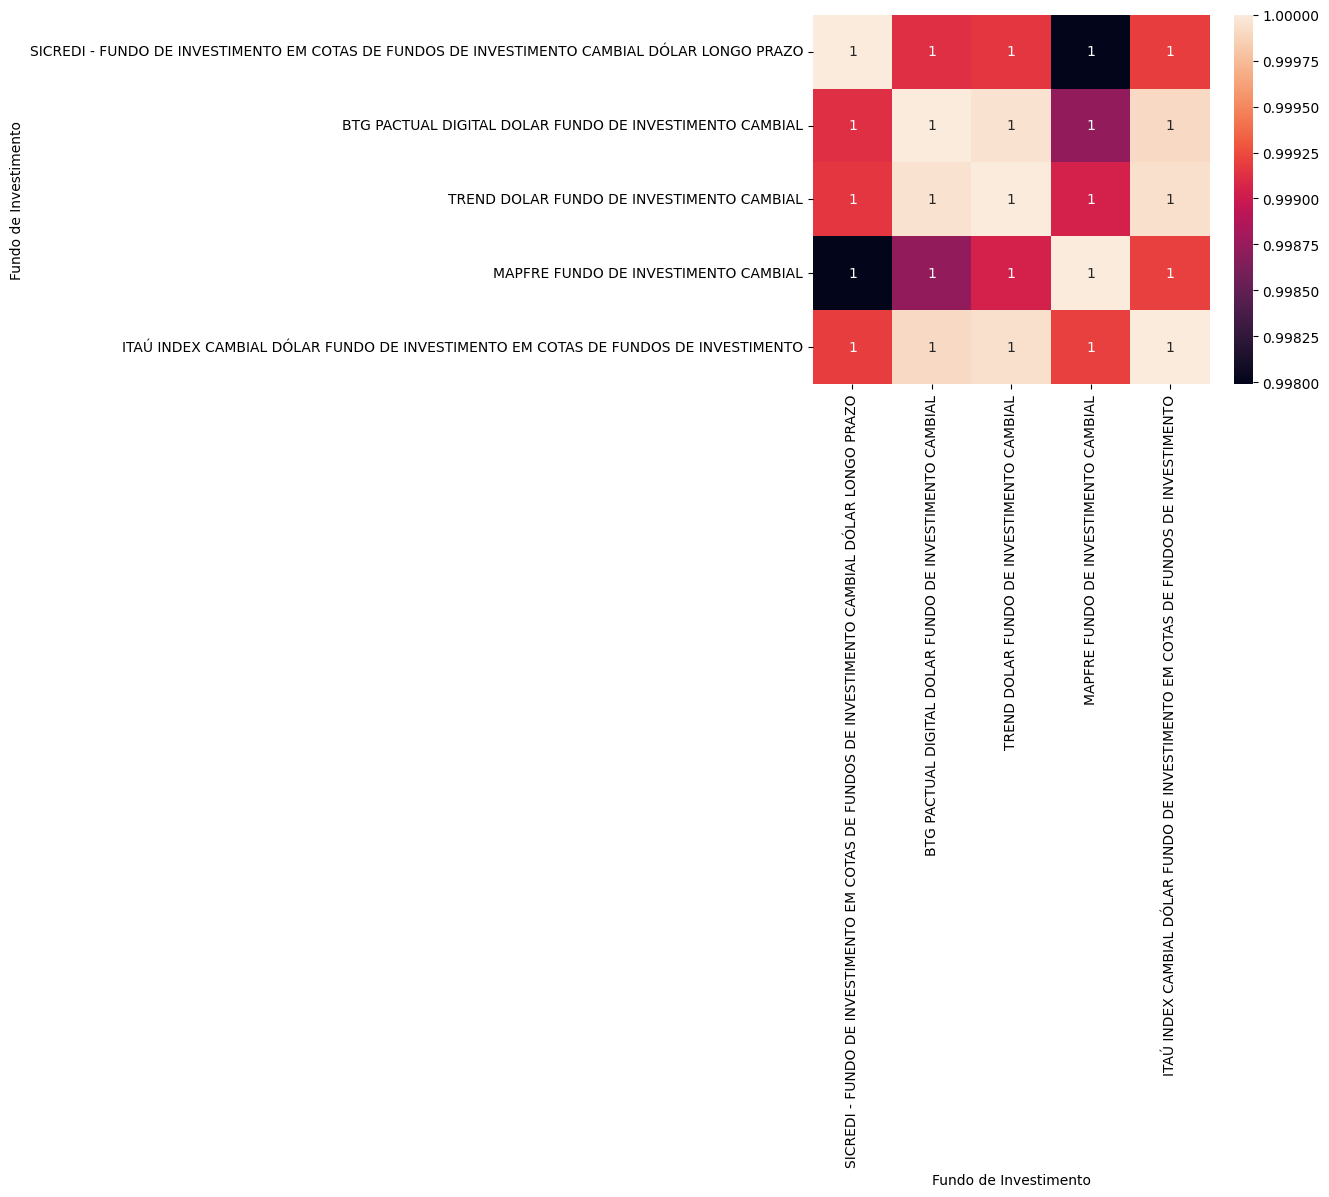

In [ ]:
sns.heatmap(cotas.iloc[:, :5].corr(), annot=True);

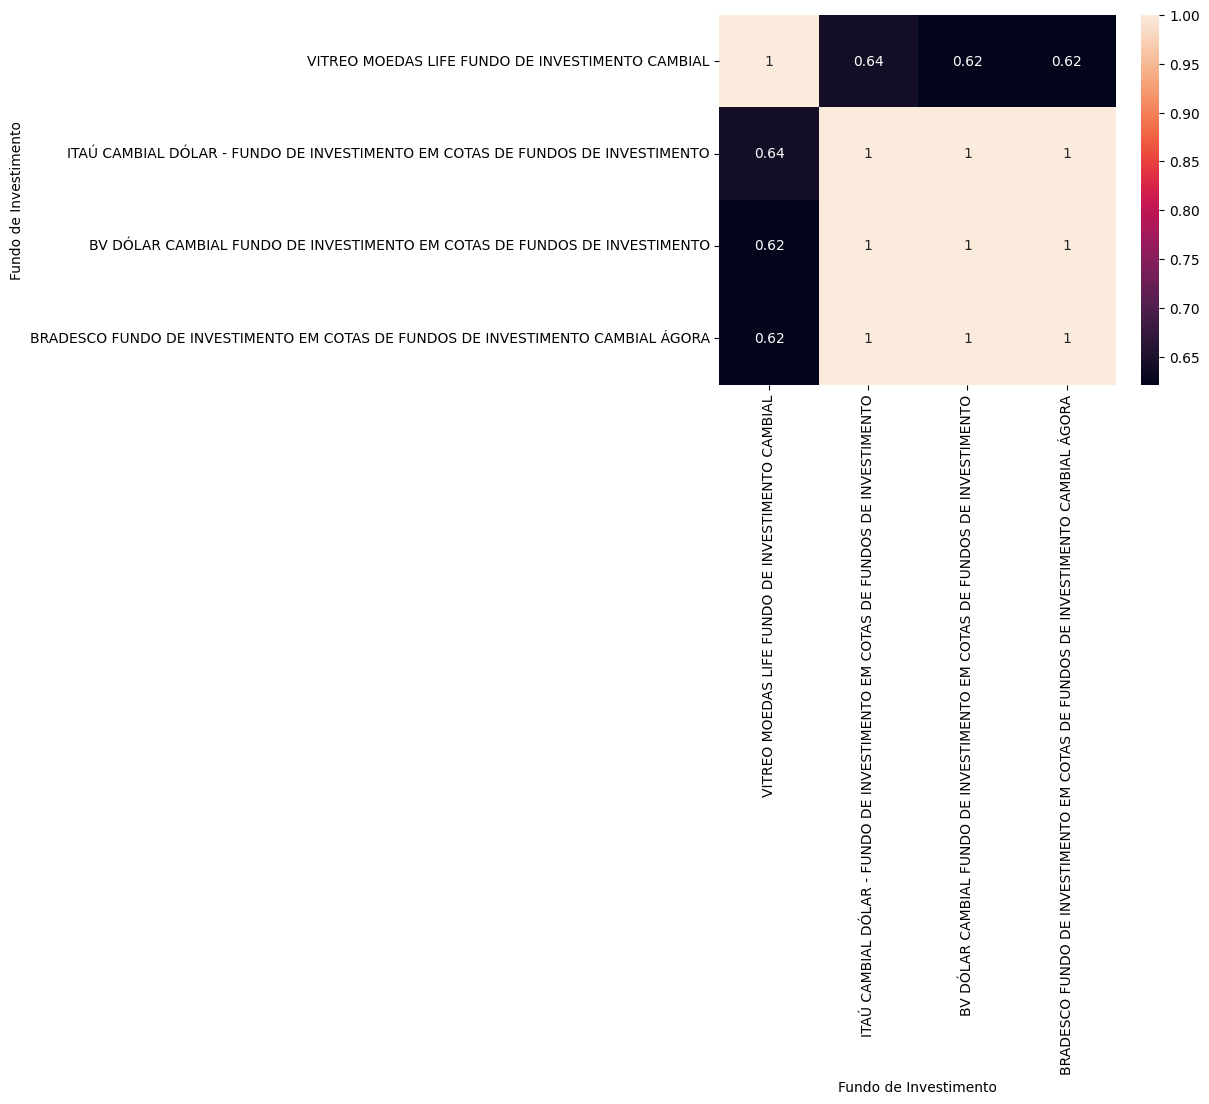

In [ ]:
sns.heatmap(cotas.iloc[:, 6:].corr(), annot=True);